# The Unreally Notebook
### Step 1 - load data & helper functions


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

from collections import Counter
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

# path to dataset
DATAPATH = 'data/upsampled_large.csv'
# device
device ='cuda'

/home/cas/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# takes in string & returns a cleaned string of all non-stop-words
def preprocess(text, lemmatizer = WordNetLemmatizer()):
    sw = set(stopwords.words('english'))
    text = re.sub(r'[^\w\s]', '', text).lower()
    s = ""
    for word in text.split():
        if word not in sw:
                s += (lemmatizer.lemmatize(word) + " ")
    return s


# creates & fits bow & tfidf vectorizer to dataset
# gets called in StanceDataset().__init__
def fit_vectorizers(dataset):
    print('fitting vectorizer...')

    # create array of all texts in dataset
    data = [preprocess(dataset.iloc[i]['head']) for i in range(len(dataset))] # headlines
    data += (preprocess(dataset.iloc[i]['body']) for i in range(len(dataset))) # bodies

    
    # fit to dataset (creates dictionary)
    bow = CountVectorizer(
        #vocabulary=vocab,
        max_features=5000,
       #ngram_range=(2, 2)
    )
    bow.fit(data)

    vocab = bow.vocabulary_
    # save for later
    vocab_df = pd.DataFrame.from_dict(vocab, orient="index")
    vocab_df.to_csv('generated_vocab.csv')

    tfidf = TfidfVectorizer(
        vocabulary=vocab,
        max_features=5000,
        #ngram_range=(2, 2) # bigrams
    )
    tfidf.fit(data)
    print('vectorizer ready!')
    return bow, tfidf

### Step 2 - define pytorch custom dataset class

In [3]:
# config

# custom dataset class
class StanceDataset(Dataset):
    def __init__(self, stance_df,  val_split=False):
        """  Initalizes vectorizers, defines train/test splits
        Args:
            stance_df (pandas.DataFrame): the dataset
        """
        self.df = stance_df
        
        self._bow, self._tfidf = fit_vectorizers(stance_df)
        
        # splits (train, test, validation) 80/20 
        self.train, self.test = train_test_split(self.df, test_size=0.2, shuffle=True)
        if val_split == True:   
            # 50/50 val/test
            self.test, self.val = train_test_split(self.test, test_size=0.5, shuffle=False)
            self.val_len = len(self.val)
        # split sizes
        self.train_len = len(self.train)
        self.test_len = len(self.test)
        
        self._lookup_dict = {'train': (self.train, self.train_len),
                             'test': (self.test, self.test_len)}
        if val_split == True:
            self._lookup_dict.update({'val': (self.val, self.val_len)})

        self.set_split('train')


    def set_split(self, split='train'):
        """ selects the splits in the dataset using a column in the dataframe 
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """
        Args:
            index (int): index to current data point
        Returns:
            dictionary holding tensor data point feature (x_data) and skalar tensor label (y_data)
        """
        
        # get text values from current row
        row = (self._target_df.iloc[index])
        claim = [row['head']]
        body = [row['body']]

        
        # transform claim (headline/tweet) and target (body) to bowTF vector
        bow_x = self._bow.transform(claim)
        bow_y = self._bow.transform(body)

        # transform claim (headline/tweet) and target (body) to TFIDF vector
        tfidf_x = self._tfidf.transform(claim)
        tfidf_y = self._tfidf.transform(body)
        
        # take cosine similary of TFIDF vectors
        cosim = cosine_similarity(tfidf_x, tfidf_y)
        
        # concat x+cosim+y to input vector & convert to tensor
        claim_df = pd.DataFrame(bow_x.toarray()) 
        body_df = pd.DataFrame(bow_y.toarray())
        cosim_df = pd.DataFrame(cosim)
        
        x_data = (pd.concat([claim_df, cosim_df, body_df],axis=1)).to_numpy()
        x_data = torch.from_numpy(x_data)

        # get stance & convert to tensor
        y_data = row['Stance']
        stance_map = {
            "agree": 0,
            "disagree": 1,
            "discuss": 2,
            "unrelated": 3
        }
        y_data = torch.tensor(stance_map[y_data])
        return {'x_data': x_data,
                'y_target': y_data}

In [88]:
def load_dataset(excel=True):
    """
    applies dataset class to dataset located at DATAPATH
    args:
        excel (bool): default true for .xlsx, else set false
    """
    print('loading dataset...')
    if excel == True:
        df = pd.read_excel(
            DATAPATH, 
            index_col=None, 
            header=0   
        )
    else:
        df = pd.read_csv(
            DATAPATH, 
            index_col=None,
            header=0   
        )
    print('loaded!')
    
    dataset = StanceDataset(df, val_split=False)
    return dataset

data = load_dataset(excel=False)

loading dataset...
loaded!
fitting vectorizer...
vectorizer ready!


In [6]:
"""
Test block for getitem. This is what the training loop will call
"""

data.set_split('train')
print("should be the lenght of train split: ", len(data._target_df))

d = data.__getitem__(1)
print(d['x_data'])
print(d['y_target'])
print(len((d['x_data'])[0]))

should be the lenght of train split:  25360
tensor([[1., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
tensor(2)
10001


### Weighted Sampler

{'unrelated': 14595, 'discuss': 7159, 'agree': 2937, 'disagree': 669}


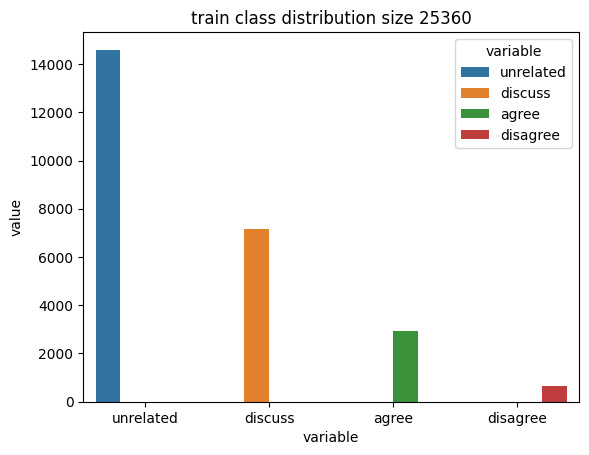

In [42]:
# distribution of labels (class distribution)
def dist_of(df):
    class_distribution = (pd.value_counts(df['Stance'])).to_dict()
    print(class_distribution)
    sns.barplot(data = pd.DataFrame.from_dict([class_distribution]).melt(), x = "variable", y="value", hue="variable").set_title(f'train class distribution size {len(df)}')

dist_of(data._target_df)

In [89]:
def sample(d):
    class_count = dict(pd.value_counts(d['Stance']))
    print(class_count)
    stance_map = {
        "agree": 0,
        "disagree": 1,
        "discuss": 2,
        "unrelated": 3
    }
    # fit the class count to sequence agree, disagree, discuss, unrelated
    cc = [0, 0, 0, 0]
    for key in class_count:
        cc[stance_map[key]] = class_count[key]

    weight = 1./torch.tensor(cc, dtype=torch.float).to(device)
    print(weight)
    
    # create array with weight for each data point
    target_list = [stance_map[(d.iloc[i]['Stance'])] for i in range(len(d))]
    samples_weight = torch.tensor([weight[t] for t in target_list]).to(device)

    weighted_sampler = WeightedRandomSampler(
        weights=samples_weight,
        num_samples=len(samples_weight),
        replacement=True
    )
    return weighted_sampler, weight

train_sampler, train_weights = sample(data._target_df)

{'unrelated': 14675, 'discuss': 7093, 'agree': 2921, 'disagree': 671}
tensor([3.4235e-04, 1.4903e-03, 1.4098e-04, 6.8143e-05], device='cuda:0')


### Step 3 - Define model & training

In [90]:
# hyperparameters
in_dim = 10001
hidden_dim = 100
out_dim = 4
bs = 64 # 32 batch size
lr = 0.001

In [91]:
# re-usable way to create dataloader
def make_batches(dataset, batch_size, shuffle=True, drop_last=True, sampler=None):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last, sampler=sampler)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


In [92]:
# define neural net
class NN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(NN, self).__init__()

        # define layers
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_dim, out_dim)
    
    # applies layers with sample x
    def forward(self, x):
        out = self.l1(x).squeeze()
        out = self.relu(out)
        out = self.l2(out)
        return out

model = NN(in_dim, hidden_dim, out_dim).to(device)

# load from file
#model.load_state_dict(torch.load('models/tfidf_50.pth'))

criterion = nn.CrossEntropyLoss(weight=train_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [94]:
"""
TRAIN function
"""

# setup
train_loss = []

def train(epoch):
  print('\n')
  # create new loader after each epoch
  data.set_split('train')
  train_loader = make_batches(data, bs, shuffle=False, sampler=train_sampler)

  model.train()

  running_loss = 0.
  last_loss = 0.
  epoch_loss = []
 
  for i, sample in enumerate(train_loader):
    # zero gradients each batch
    optimizer.zero_grad()
    
    inputs = ((sample)['x_data']).float()
    labels = sample['y_target']

    # predict for batch
    outputs = model(inputs)

    # compute loss and gradients
    loss = criterion(outputs, labels)
    epoch_loss.append(loss.item())
    loss.backward()

    # adjust weights
    optimizer.step()

    # intra-epoch reporting
    running_loss += loss.item()
    if i % 100 == 0:
            last_loss = running_loss / bs # 1000 loss per batch
            print('Epoch {} batch {} loss: {}'.format(epoch + 1, i + 1, last_loss))
            running_loss = 0.
    
  train_loss.append(sum(epoch_loss)/len(epoch_loss))

In [95]:
""" 
TEST function
"""

# setup
eval_loss = []
y_pred = []
y_true = []

def test(epoch):
  # create new loader after each epoch
  data.set_split('test')
  test_loader = make_batches(data, bs, shuffle=True)

  epoch_loss = []
  model.eval()
 
  with torch.no_grad():
    for i, sample in enumerate(test_loader):
      inputs = ((sample)['x_data']).float()
      labels = sample['y_target']
      
      # predict
      outputs=model(inputs)

      # compute loss
      loss = criterion(outputs, labels)
      epoch_loss.append(loss.item())

      # get metrics for feature report on last epoch
      if epoch == epochs-1:
        _, predictions = torch.max(outputs, 1)
        y_pred.extend(predictions.data.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())
      
 
  eval_loss.append(sum(epoch_loss)/len(epoch_loss))

In [96]:
epochs = 40
for epoch in range(epochs): 
  train(epoch)
  test(epoch)



Epoch 1 batch 1 loss: 0.022645248100161552
Epoch 1 batch 101 loss: 0.9641298823989928
Epoch 1 batch 201 loss: 0.6215607661288232
Epoch 1 batch 301 loss: 0.52631003013812


Epoch 2 batch 1 loss: 0.005420024041086435
Epoch 2 batch 101 loss: 0.42926046531647444
Epoch 2 batch 201 loss: 0.42144913342781365
Epoch 2 batch 301 loss: 0.3796704225242138


Epoch 3 batch 1 loss: 0.003912163898348808
Epoch 3 batch 101 loss: 0.32975431240629405
Epoch 3 batch 201 loss: 0.30199478031136096
Epoch 3 batch 301 loss: 0.3050332966959104


Epoch 4 batch 1 loss: 0.0015821483684703708
Epoch 4 batch 101 loss: 0.2635701444814913
Epoch 4 batch 201 loss: 0.24473545560613275
Epoch 4 batch 301 loss: 0.24594362726202235


Epoch 5 batch 1 loss: 0.002481879200786352
Epoch 5 batch 101 loss: 0.22468359855702147
Epoch 5 batch 201 loss: 0.19061365601373836
Epoch 5 batch 301 loss: 0.19270906821475364


Epoch 6 batch 1 loss: 0.004689055494964123
Epoch 6 batch 101 loss: 0.17691008650581352
Epoch 6 batch 201 loss: 0.1817278

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# load from file
lossdata = pd.read_csv('measures/bowtf_loss_40.csv')

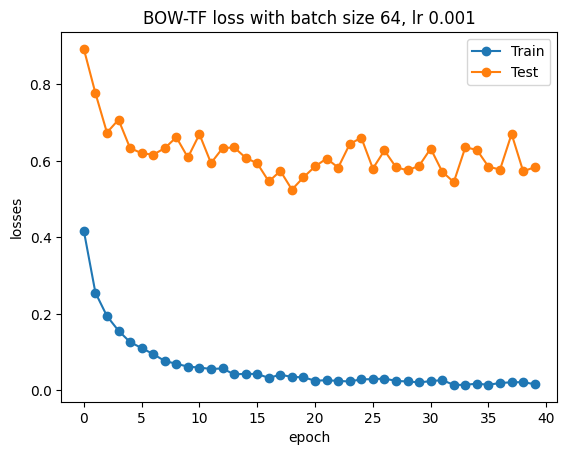

In [5]:


plt.plot(lossdata['train'], '-o') # train_loss
plt.plot(lossdata['eval'],'-o') # eval_loss
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test']) # 
plt.title(f'BOW-TF loss with batch size {bs}, lr {lr}')

plt.show()

In [98]:
# save losses to data frame
pd.DataFrame({'train': train_loss, 'eval': eval_loss}).to_csv("measures/bowtf_loss_40.csv")

In [101]:
from sklearn.metrics import classification_report
 
print(classification_report(y_true, y_pred, 
    target_names = ['agree', 'disagree', 'discuss', 'unrelated']
))



              precision    recall  f1-score   support

       agree       0.87      0.93      0.90       756
    disagree       0.68      0.75      0.71       169
     discuss       0.97      0.95      0.96      1814
   unrelated       0.99      0.99      0.99      3597

    accuracy                           0.96      6336
   macro avg       0.88      0.90      0.89      6336
weighted avg       0.96      0.96      0.96      6336



In [102]:
# save the model
torch.save(model.state_dict(), "models/bowtf_40.pth")

[[8.67901235e-01 1.40540541e-01 1.06981982e-02 2.24403927e-03]
 [4.07407407e-02 6.81081081e-01 4.50450450e-03 5.61009818e-04]
 [7.90123457e-02 1.24324324e-01 9.66216216e-01 3.08555400e-03]
 [1.23456790e-02 5.40540541e-02 1.85810811e-02 9.94109397e-01]]


<AxesSubplot: title={'center': 'cf matrix of testadata size 6340, lr: 0.001, batches: 64, epochs: 40'}>

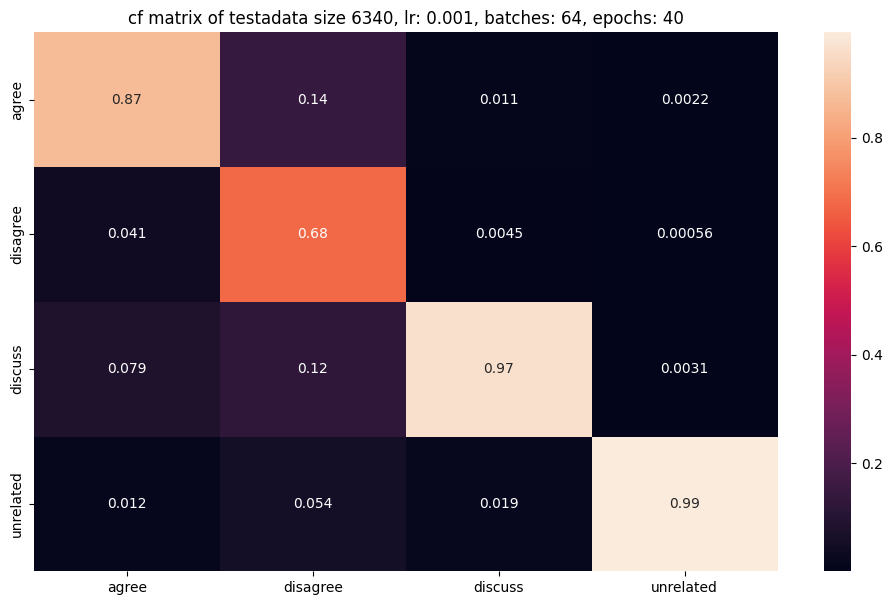

In [103]:
# confusion matrix
classes = ['agree', 'disagree', 'discuss', 'unrelated']

# Build confusion matrix (normalized as precision)
cf_matrix = confusion_matrix(y_true, y_pred, normalize='pred')
# precision, is in a sense correctness, and recall is completeness.

print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title(f'cf matrix of testadata size {len(data._target_df)}, lr: {lr}, batches: {bs}, epochs: {epochs}')
sns.heatmap(df_cm, annot=True)